# Object Detection Batch Inference with PyTorch


This example demonstrates how to do object detection batch inference at scale with a pre-trained PyTorch model and Ray Data.

Source: https://docs.ray.io/en/latest/data/examples/batch_inference_object_detection.html

In [1]:
# Requirements
# !pip install "ray[data]" torchvision

In [2]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()


2023-09-06 14:40:21,403	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.18
Ray version:,2.6.3
Dashboard:,http://127.0.0.1:8265


## Object Detection on a single Image with PyTorch

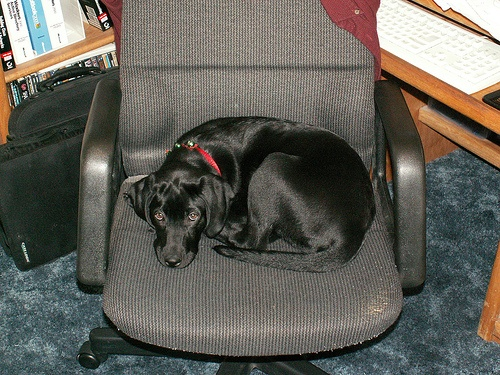

In [3]:
import requests
from PIL import Image

url = "https://s3-us-west-2.amazonaws.com/air-example-data/AnimalDetection/JPEGImages/2007_000063.jpg"
img = Image.open(requests.get(url, stream=True).raw)
display(img)

load and intialize a pre-trained PyTorch model.

In [4]:
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [5]:
image = transforms.Compose([transforms.PILToTensor()])(img)
preprocess = weights.transforms()
batch = [preprocess(image)]

In [6]:
prediction = model(batch)[0]

In [7]:
prediction

{'boxes': tensor([[121.7145, 117.4496, 377.1662, 271.2569],
         [376.1469,   0.5863, 500.0000,  92.7730],
         [ 69.7076,   6.6619, 426.4802, 361.7069]], grad_fn=<StackBackward0>),
 'labels': tensor([18, 76, 62]),
 'scores': tensor([0.9989, 0.9875, 0.9486], grad_fn=<IndexBackward0>)}

In [8]:
weights.meta["categories"][62]

'chair'

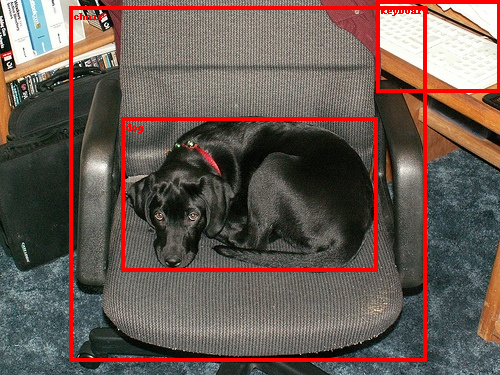

In [9]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(image, 
                          boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4)
im = to_pil_image(box.detach())
display(im)

## Scaling with Ray Data

### Loading the Image Dataset

In [10]:
import ray

ds = ray.data.read_images("s3://anonymous@air-example-data/AnimalDetection/JPEGImages")
display(ds.schema())

Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

### Batch inference with Ray Data

#### Preprocessing


In [11]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.models.detection import (FasterRCNN_ResNet50_FPN_V2_Weights,
                                          fasterrcnn_resnet50_fpn_v2)
from typing import Dict


def preprocess_image(data: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    preprocessor = transforms.Compose(
        [transforms.ToTensor(), weights.transforms()]
    )
    return {
        "image": data["image"],
        "transformed": preprocessor(data["image"]),
    }

In [12]:
ds = ds.map(preprocess_image)

In [13]:
ds.take(1)

2023-09-06 14:40:59,395	INFO dataset.py:2180 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.


2023-09-06 14:40:59,397	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map(preprocess_image)]
2023-09-06 14:40:59,397	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 14:40:59,397	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

[{'image': array([[[172, 154, 144],
          [255, 248, 239],
          [255, 246, 244],
          ...,
          [255, 255, 246],
          [237, 234, 225],
          [214, 211, 202]],
  
         [[123, 105,  95],
          [255, 249, 240],
          [251, 244, 238],
          ...,
          [255, 252, 245],
          [255, 254, 247],
          [247, 244, 237]],
  
         [[ 54,  38,  25],
          [255, 253, 241],
          [250, 247, 238],
          ...,
          [248, 247, 243],
          [248, 247, 243],
          [254, 253, 249]],
  
         ...,
  
         [[ 64,  79,  86],
          [ 61,  74,  80],
          [104, 113, 118],
          ...,
          [ 94, 105, 109],
          [ 90,  99, 104],
          [ 83,  92,  97]],
  
         [[ 69,  86,  93],
          [ 68,  83,  88],
          [ 53,  64,  68],
          ...,
          [ 83,  97,  98],
          [ 55,  69,  70],
          [ 82,  96,  97]],
  
         [[ 68,  87,  94],
          [ 42,  61,  67],
          [ 78,

In [14]:
single_batch = ds.take_batch(batch_size=3)
display(single_batch)

2023-09-06 14:41:19,527	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map(preprocess_image)]
2023-09-06 14:41:19,527	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 14:41:19,528	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

{'image': array([array([[[ 73,  79,  65],
                [ 82,  88,  76],
                [ 85,  86,  78],
                ...,
                [ 22,   2,   3],
                [ 22,   2,   3],
                [ 21,   1,   2]],
 
               [[ 86,  92,  78],
                [ 82,  85,  74],
                [ 76,  77,  69],
                ...,
                [ 22,   2,   3],
                [ 22,   2,   3],
                [ 21,   1,   2]],
 
               [[ 82,  85,  74],
                [ 79,  82,  71],
                [ 75,  76,  68],
                ...,
                [ 22,   2,   3],
                [ 22,   2,   3],
                [ 21,   1,   2]],
 
               ...,
 
               [[ 37,  40,  81],
                [ 35,  38,  79],
                [ 32,  33,  77],
                ...,
                [ 36,  26,  25],
                [ 17,   5,   7],
                [  9,   0,   0]],
 
               [[ 51,  56,  98],
                [ 46,  49,  92],
               

In [15]:
class ObjectDetectionModel:
    def __init__(self):
        # Define the model loading and initialization code in `__init__`.
        self.weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
        self.model = fasterrcnn_resnet50_fpn_v2(
            weights=self.weights,
            box_score_thresh=0.9,
        )
        if torch.cuda.is_available():
            # Move the model to GPU if it's available.
            self.model = self.model.cuda()
        self.model.eval()

    def __call__(self, input_batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        # Define the per-batch inference code in `__call__`.
        batch = [torch.from_numpy(image) for image in input_batch["transformed"]]
        if torch.cuda.is_available():
            # Move the data to GPU if it's available.
            batch = [image.cuda() for image in batch]
        predictions = self.model(batch)
        return {
            "image": input_batch["image"],
            "labels": [pred["labels"].detach().cpu().numpy() for pred in predictions],
            "boxes": [pred["boxes"].detach().cpu().numpy() for pred in predictions],
        }

In [16]:
# ds_predictions = ds.map_batches(
#     ObjectDetectionModel,
#     compute=ray.data.ActorPoolStrategy(size=1), # Use 1 GPUs. Change this number based on the number of GPUs in your cluster.
#     batch_size=4, # Use the largest batch size that can fit in GPU memory.
#     num_gpus=1,  # Specify 1 GPU per model replica. Remove this if you are doing CPU inference.
# )

ds_predictions = ds.map_batches(
    ObjectDetectionModel,
    num_gpus=1,
    compute=ray.data.ActorPoolStrategy(size=1),
)

### Verify and Save Results

In [17]:
from torchvision.transforms.functional import convert_image_dtype, to_tensor

batch = ds_predictions.take_batch(batch_size=2)
for image, labels, boxes in zip(batch["image"], batch["labels"], batch["boxes"]):
    image = convert_image_dtype(to_tensor(image), torch.uint8)
    labels = [weights.meta["categories"][i] for i in labels]
    boxes = torch.from_numpy(boxes)
    img = to_pil_image(draw_bounding_boxes(
        image,
        boxes,
        labels=labels,
        colors="red",
        width=4,
    ))
    display(img)

2023-09-06 14:41:37,672	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map(preprocess_image)] -> ActorPoolMapOperator[MapBatches(ObjectDetectionModel)]
2023-09-06 14:41:37,673	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 14:41:37,673	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-06 14:41:37,784	INFO actor_pool_map_operator.py:117 -- MapBatches(ObjectDetectionModel): Waiting for 2 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]